In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import openTSNE
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision

import sys
sys.path.append("../scripts")

import models
import utils
import data
import train

%load_ext autoreload
%autoreload 2

In [2]:
def get_model(dec = False, k = 10, latent_dim = 128):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = models.AutoEncoder(
        latent_dim = latent_dim,
        encoder_arch = "resnet50_small_patch",
        decoder_layers_per_block = [3] * 5
    )
    if dec:
        model = models.DEC(
            n_clusters = k,
            embedding_dim = latent_dim,
            encoder = model.encoder
        )
        model.load_state_dict(torch.load(f"../models/DEC_resnet50_small_{latent_dim}_k_{k}/model.pt"))
    else:
        model.load_state_dict(torch.load(f"../model/AE_resnet50_small_{latent_dim}/model.pt"))
    model.to(device)
    return model


In [3]:
def get_embeddings(dl, model):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    embeddings = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dl):
            batch = batch.to(device)
            batch_size = batch.shape[0]
            z = model.encoder(batch).detach().cpu().numpy().reshape(batch_size, -1)
            embeddings.append(z)
    embeddings = np.concatenate(embeddings)
    return embeddings

In [5]:
def get_embeddings_cluster(dl, model):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    embeddings = []
    clusters = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dl):
            batch = batch.to(device)
            z = model.encoder(batch).detach().cpu().numpy()
            c = model(batch).detach().cpu().numpy()
            embeddings.append(z)
            clusters.append(c)
        
    embeddings = np.concatenate(embeddings)
    clusters = np.concatenate(clusters).argmax(axis = 1)
    return embeddings, clusters


In [6]:
def proj_embeddings(embeddings, samples):
    embeddings_proj = openTSNE.TSNE(
        initialization="pca",
        perplexity = 250,
        #exaggeration = 4,
        metric = "cosine",
        n_jobs=32
    ).fit(embeddings[:samples, :])
    embeddings_proj = embeddings_proj.prepare_partial(embeddings)

    # place coordinates in [-1, 1 ]²
    for i in range(2):
        embeddings_proj[:, i] -= embeddings_proj[:, i].min()
        embeddings_proj[:, i] /= embeddings_proj[:, i].max()
        embeddings_proj[:, i] *= 2
        embeddings_proj[:, i] -= 1
        
    return embeddings_proj

In [7]:
filenames = data.get_filenames_center_blocks(patches_count_max=10)
#filenames = filenames[:100000]
print(f"Total of images: {len(filenames)}")
filenames_fixed = [f[7:-2] for f in filenames]
dataset = data.SmallPatchesDataset(filenames)
dl = DataLoader(dataset, batch_size = 600)

100%|██████████| 54477/54477 [00:21<00:00, 2525.87it/s]


Total of images: 534299


## Embeddings of AE

In [41]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

for latent_dim in [32, 64, 128, 256, 512]:
    model = get_model(
        dec = False,
        latent_dim = latent_dim
    )
    embeddings = get_embeddings(dl, model)
    embeddings_proj = proj_embeddings(embeddings, 10000)
    results = pd.DataFrame({
        "x" : embeddings_proj[:, 0], 
        "y" : embeddings_proj[:, 1], 
        "path" : filenames_fixed, 
        "cluster" : np.ones(len(filenames))
    })
    results.to_csv(f"../../SatImgEmbeddingVis/data/AE_resnet50_small_{latent_dim}_proj.csv")

100%|██████████| 4167/4167 [41:31<00:00,  1.67it/s]


## Embeddings of DEC

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
latent_dim = 128
for k in [10, 20, 30, 50]:
    model = get_model(
        dec = True,
        k = k,
        latent_dim = latent_dim
    )    
    embeddings, clusters = get_embeddings_cluster(dl, model)
    embeddings_proj = proj_embeddings(embeddings, 50000)
    results = pd.DataFrame({"x" : embeddings_proj[:, 0], "y" : embeddings_proj[:, 1], "path" : filenames_fixed, "cluster" : clusters})
    results.to_csv(f"../../SatImgEmbeddingVis/data/DEC_resnet50_small_{latent_dim}_k_{k}_proj.csv")

In [19]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
latent_dim = 512
for k in [10, 20, 30, 50]:
    model = get_model(
        dec = True,
        k = k,
        latent_dim = latent_dim
    )    
    embeddings, clusters = get_embeddings_cluster(dl, model)
    embeddings_proj = proj_embeddings(embeddings, 30000)
    results = pd.DataFrame({"x" : embeddings_proj[:, 0], "y" : embeddings_proj[:, 1], "path" : filenames_fixed, "cluster" : clusters})
    results.to_csv(f"../../SatImgEmbeddingVis/data/DEC_resnet50_small_{latent_dim}_k_{k}_proj.csv")

100%|██████████| 667/667 [14:42<00:00,  1.32s/it]


## Resnet50 (without training)

In [42]:
filenames = data.get_filenames_center_blocks()
filenames = filenames[:200000]
print(f"Total of images: {len(filenames)}")
filenames_fixed = [f[7:-2] for f in filenames]
dataset = data.SmallPatchesDataset(filenames, resize = (224, 224))
dl = DataLoader(dataset, batch_size = 300)

Total of images: 200000


In [44]:
model = torchvision.models.resnet50(weights = "DEFAULT")
model = nn.Sequential(*list(model.children())[:-1]).to(device)

In [45]:
def get_embeddings_resnet50(dl, model):
    embeddings = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dl):
            batch = batch.to(device)
            batch_size = batch.shape[0]
            z = model(batch).detach().cpu().numpy().reshape(batch_size, -1)
            embeddings.append(z)

    embeddings = np.concatenate(embeddings)
    return embeddings
embeddings = get_embeddings_resnet50(dl, model)

  0%|          | 0/667 [00:00<?, ?it/s]

/home/giovani/miniconda3/envs/urban_gdp/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 667/667 [13:34<00:00,  1.22s/it]


In [59]:
embeddings_proj = proj_embeddings(embeddings, 50000)
kmeans = KMeans(n_clusters = 30, random_state = 0).fit(embeddings_proj)
results = pd.DataFrame({"x" : embeddings_proj[:, 0], "y" : embeddings_proj[:, 1], "path" : filenames_fixed, "cluster" : kmeans.labels_})#
results.to_csv(f"../../SatImgEmbeddingVis/data/ResNet50_proj.csv")

/home/giovani/miniconda3/envs/urban_gdp/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Autoencoder with ResNet as feature extractor

In [22]:
dataset = data.SmallPatchesDataset(filenames, resize=(224, 224))
dl = DataLoader(dataset, batch_size = 300)

In [23]:
def get_model_feature_extractor(latent_dim = 128):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = models.AutoEncoderResnetExtractor(latent_dim)
    model.load_state_dict(torch.load(f"../models/AE_extractor_resnet50_small_{latent_dim}/model.pt"))
    model.to(device)
    return model


In [24]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

for latent_dim in [64, 128, 256]:
    model = get_model_feature_extractor(
        latent_dim = latent_dim
    )
    embeddings = get_embeddings(dl, model)
    embeddings_proj = proj_embeddings(embeddings, 50000)
    results = pd.DataFrame({
        "x" : embeddings_proj[:, 0], 
        "y" : embeddings_proj[:, 1], 
        "path" : filenames_fixed, 
        "cluster" : np.ones(len(filenames))
    })
    results.to_csv(f"../../SatImgEmbeddingVis/data/AE_extractor_resnet50_small_{latent_dim}_proj.csv")

  0%|          | 0/1789 [00:00<?, ?it/s]/home/giovani/miniconda3/envs/urban_gdp/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/1789 [00:00<?, ?it/s]/home/giovani/miniconda3/envs/urban_gdp/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all t

## New models with more training

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.AutoEncoder(
    latent_dim = 128,
    encoder_arch = "resnet50_small_patch",
    decoder_layers_per_block = [3] * 5,
    denoising = True
)
model.load_state_dict(torch.load("../models/AE_resnet50_small_patch_128_long/model.pt"))
model.to(device);

In [9]:
embeddings = get_embeddings(dl, model)

  0%|          | 0/891 [00:00<?, ?it/s]

100%|██████████| 891/891 [29:45<00:00,  2.00s/it]


In [10]:
kmeans = KMeans(n_clusters = 50, n_init = 10).fit(embeddings)

In [21]:
utils.plot_cluster_results(dataset, kmeans.labels_, "../models/AE_resnet50_small_patch_128_long/kmeans_clusters")

In [22]:
import joblib

In [23]:
joblib.dump(kmeans, "../models/AE_resnet50_small_patch_128_long/kmeans.joblib")

['../models/AE_resnet50_small_patch_128_long/kmeans.joblib']

In [24]:
embeddings_proj = proj_embeddings(embeddings, 25000)

In [25]:
results = pd.DataFrame({
    "x" : embeddings_proj[:, 0], 
    "y" : embeddings_proj[:, 1], 
    "path" : filenames_fixed, 
    "cluster" : kmeans.labels_
})
results.to_csv(f"../../SatImgEmbeddingVis/data/AE_resnet50_small_patch_128_long_proj.csv")

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.AutoEncoderResnetExtractor(
    dims = [2048, 1024, 256, 128]
)
model.load_state_dict(torch.load("../models/AE_extractor_resnet50_small_128_long/model.pt"))
model.to(device);

In [27]:
embeddings = get_embeddings(dl, model)
#embeddings_proj = proj_embeddings(embeddings, 50000)

  0%|          | 0/891 [00:00<?, ?it/s]

100%|██████████| 891/891 [29:13<00:00,  1.97s/it]


In [28]:
kmeans = KMeans(n_clusters = 50, n_init = 10).fit(embeddings)

In [32]:
utils.plot_cluster_results(dataset, kmeans.labels_, "../models/AE_extractor_resnet50_small_128_long/kmeans_clusters")

In [33]:
joblib.dump(kmeans, "../models/AE_extractor_resnet50_small_128_long/kmeans.joblib")

['../models/AE_extractor_resnet50_small_128_long/kmeans.joblib']

In [30]:
results = pd.DataFrame({
    "x" : embeddings_proj[:, 0], 
    "y" : embeddings_proj[:, 1], 
    "path" : filenames_fixed, 
    "cluster" : kmeans.labels_
})
results.to_csv(f"../../SatImgEmbeddingVis/data/AE_extractor_resnet50_small_128_long_proj.csv")

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.AutoEncoderResnetExtractor(
    dims = [2048, 128, 64]
)
model.load_state_dict(torch.load("../models/AE_extractor_resnet50_small_64/model.pt"))
model.to(device);

In [51]:
embeddings = get_embeddings(dl, model)

100%|██████████| 891/891 [28:24<00:00,  1.91s/it]


In [52]:
kmeans = KMeans(n_clusters = 50, n_init = 10).fit(embeddings)

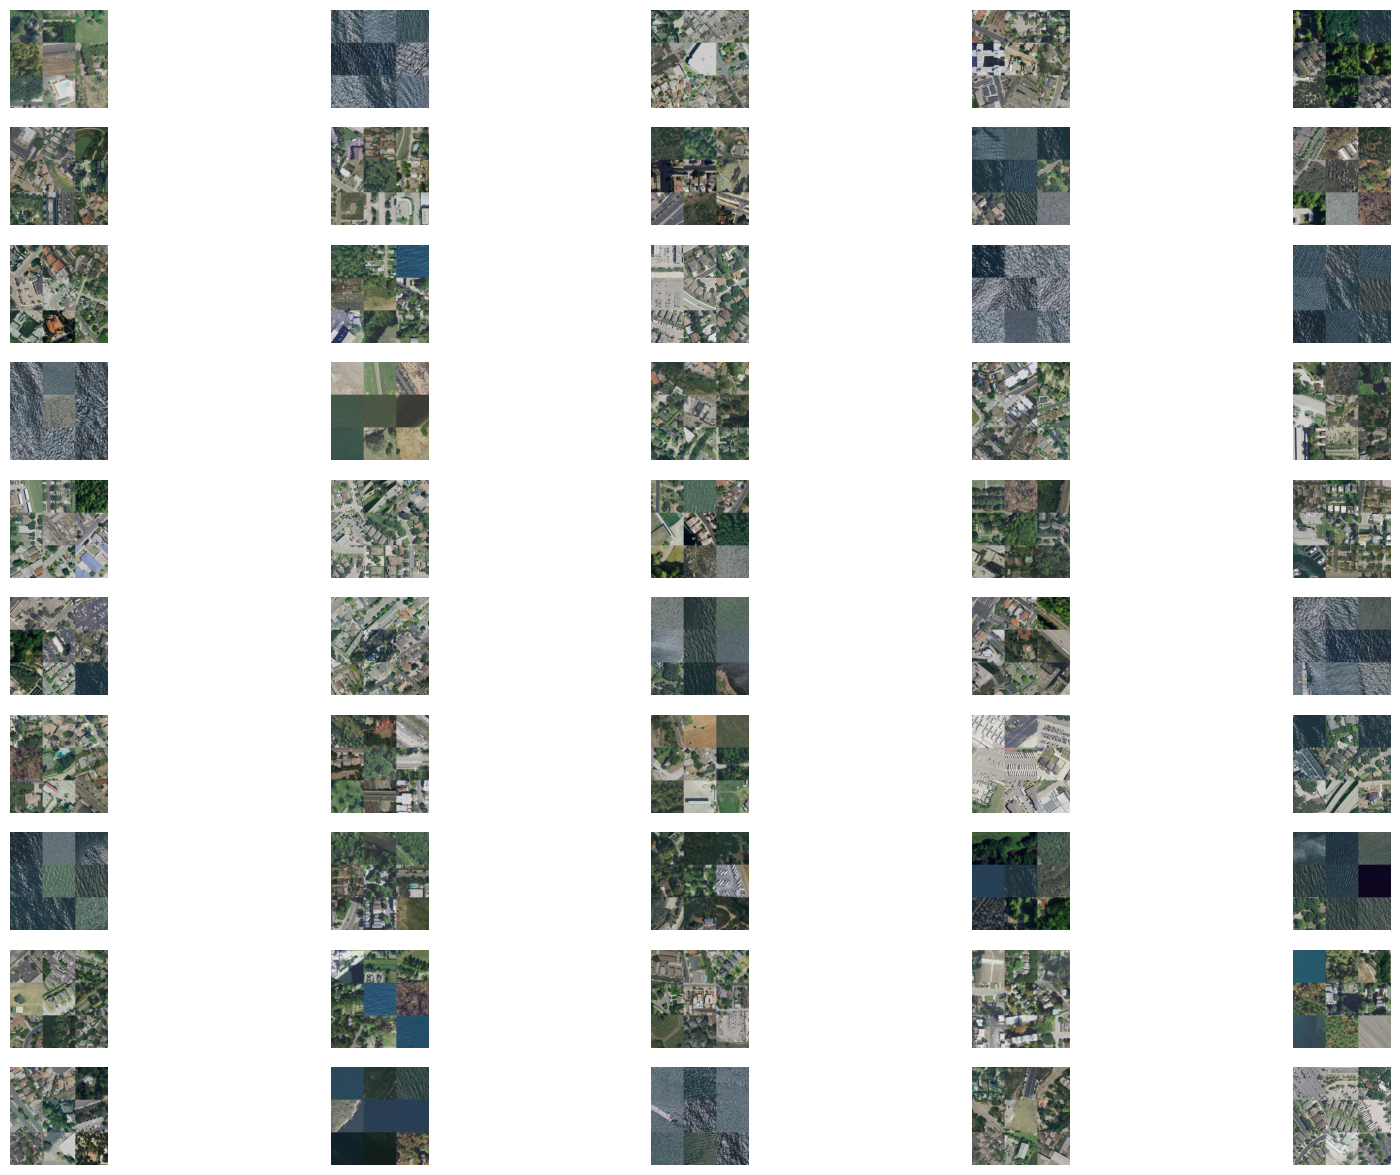

In [53]:
utils.plot_cluster_results(dataset, kmeans.labels_)

In [58]:
model = models.AutoEncoderResnetExtractor(
    dims = [2048, 32]
).to(device)

In [61]:
embeddings = train.train_reconstruction_feature_extraction(
    model,
    dl,
    return_embeddings = True,
    epochs = 1
)

  0%|          | 0/891 [00:00<?, ?it/s]

100%|██████████| 891/891 [41:27<00:00,  2.79s/it]

Epoch 1/1 - Loss: 26.82865761


In [64]:
kmeans = KMeans(n_clusters = 50, n_init = 20).fit(embeddings)

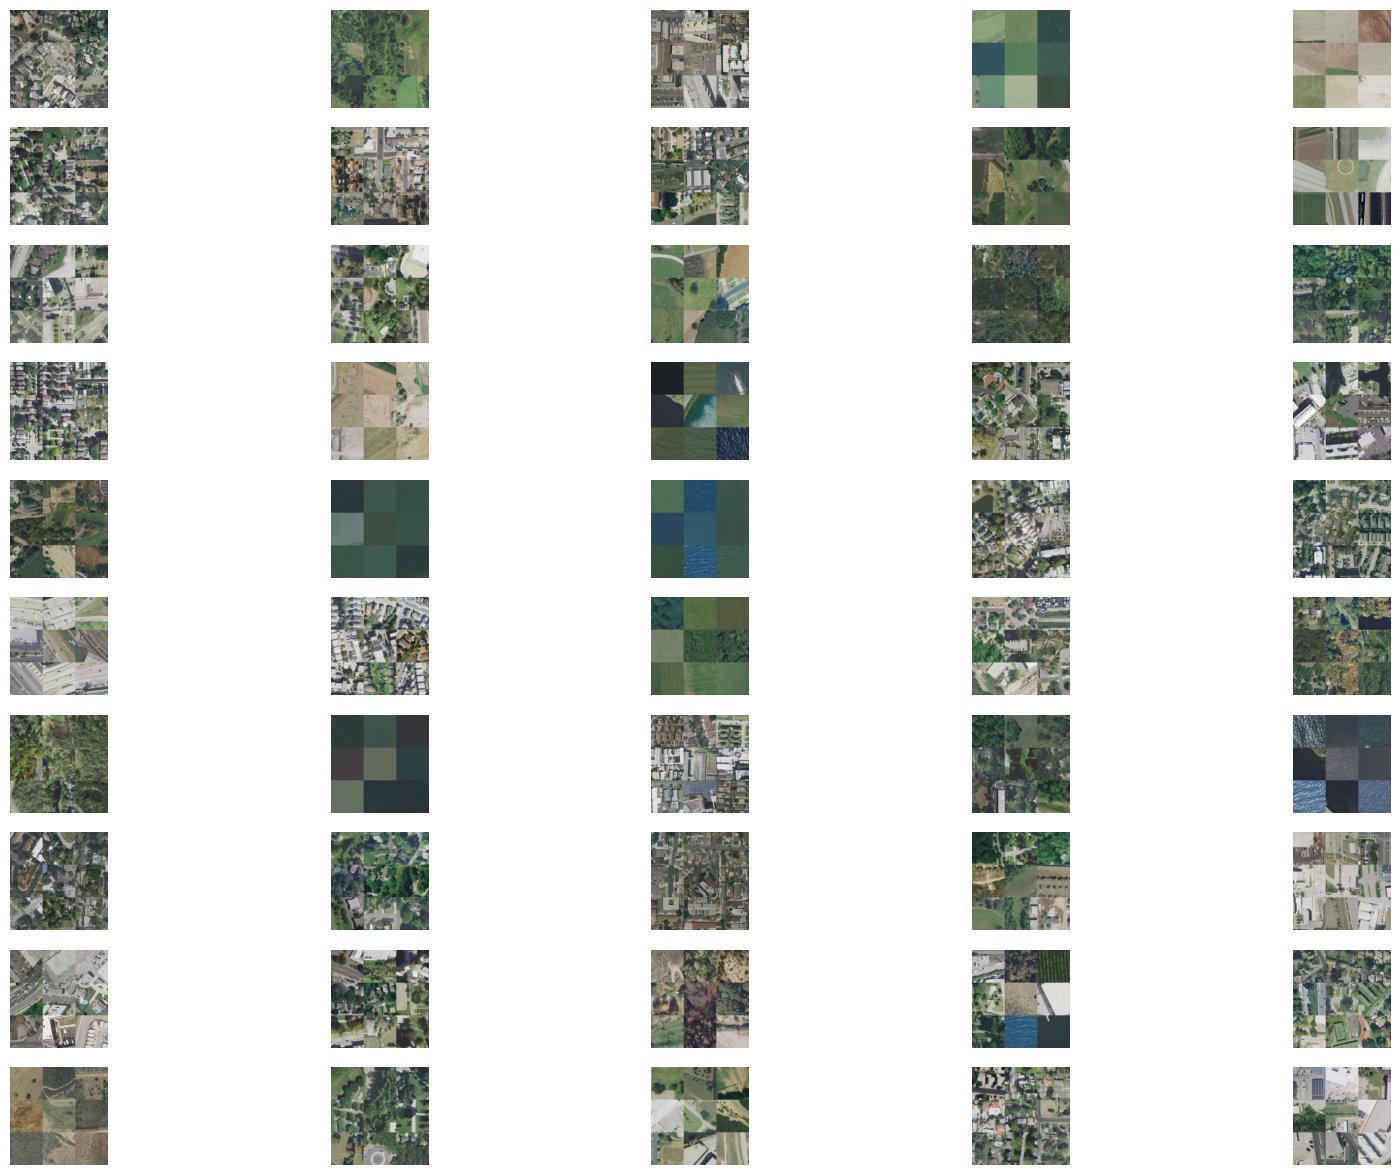

In [65]:
utils.plot_cluster_results(dataset, kmeans.labels_)